<a href="https://colab.research.google.com/github/rtang1997/BPETEL/blob/main/repeat_generative_model_MMD_digit_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
is_copied=0
#is_copied=1
bandwidth=0.01
#bandwidth=0
batch_size=256
#batch_size=128
center=5
#center=1
dataset='digit'
#dataset='fashion'
latent_dim=8
#latent_dim=4
pou='indicator'
gamma=3
#pou='smooth'

In [3]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math, os
from numpy import array as matrix, arange
from numpy import zeros, ones,empty
import tensorflow_datasets
import random
import math
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

  
from matplotlib import pyplot as plt
import math, os
from numpy import array as matrix, arange
from numpy import zeros, ones,empty
import tensorflow_datasets
import random
import math
import sklearn
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tensorflow.keras import datasets, layers, models,constraints
 

In [29]:
from tensorflow.keras import datasets, layers, models,constraints

In [30]:
if dataset=='fashion':
 (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
if dataset=='digit':
 (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [31]:
x_train=np.reshape(x_train/255, (x_train.shape[0],784))
x_test=np.reshape(x_test/255, (x_test.shape[0],784))


In [7]:
from sklearn.cluster import MiniBatchKMeans
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=center,batch_size=1000)
kmeans = kmeans.fit(x_train)
A=kmeans.cluster_centers_

In [32]:
nn=x_train.shape[0]
gg=zeros((center,nn))
for i in range(nn):
  for j in range(center):
    gg[j,i]=np.dot(np.transpose(x_train[i,:]-A[j,:]),(x_train[i,:]-A[j,:]))
label=zeros((nn,1))
for i in range(nn):
  label[i,0]=np.argmin(gg[:,i])
radius=zeros((center,1))
for i in range(center):
  radius[i,0]=np.max(gg[i,np.where(label[:,0]==i)])**0.5+1


60000

In [33]:
 
if pou=='smooth':
  def rho(xindex,r,cindex,gg):
    z=gg[cindex,xindex]**0.5
    if r>=z:
      return (r**2-z**2)**gamma
    else:
      return 0

  def trho(index,xindex,gg):
    z=0
    for j in range(center):
      z=z+rho(xindex,radius[j,0],j,gg)
    return rho(xindex,radius[index,0],index,gg)/z
  prob=zeros((center,1))
  for j in range(center):
    for i in  range(nn):
      prob[j,0]=prob[j,0]+trho(j,i,gg)/nn     

if pou=='indicator':
   prob=zeros((center,1))
   for j in range(center):
        prob[j,0]=len(np.where(label==j)[0])/nn

'indicator'

In [34]:


nprob=empty((center,1))
for j in range(center):
   nprob[j,0]=round(prob[j,0]*100)
nprob[np.argmax(nprob)]=nprob[np.argmax(nprob)]+100-sum(nprob)
nnprob=empty((center,1))
for j in range(center):
   nnprob[j,0]=round(prob[j,0]*10000)

In [35]:
 

 
input_dim=28
n_channel=1
 


In [36]:
def compute_kernel(x, y,h):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
   
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1,]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return 2*h*tf.cast(dim, tf.float32)/(2*h*tf.cast(dim, tf.float32)+tf.reduce_sum(tf.square(tiled_x - tiled_y), axis=2))


def compute_mmd(x, y):
    stat=0
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
   
    for scale in [1]:
        h=scale
        x_kernel = compute_kernel(x, x,h)-tf.eye(x_size)
     
        y_kernel = compute_kernel(y, y,h)-tf.eye(y_size)
      
        xy_kernel = compute_kernel(x, y,h)
       
        stat=stat+ tf.cast(x_size/(x_size-1),'float32')*tf.reduce_mean(x_kernel)  + tf.cast(y_size/(y_size-1),'float32')*tf.reduce_mean(y_kernel)  - 2 * tf.reduce_mean(xy_kernel)
    return stat


In [37]:
def convert_to_display(samples):
    cnt, height, width,depth = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2],sample.shape[3]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

In [53]:

encoder_inputs = keras.Input(shape=(28, 28, 1))
x=layers.Conv2D(3, 3,strides=1)(encoder_inputs)
x = layers.LeakyReLU(0.1)(x)
x = layers.Conv2D(32, 3,strides=2)(x)
 
x = layers.LeakyReLU(0.1)(x)
x = layers.Conv2D(64, 3,strides=2)(x)
 
x = layers.LeakyReLU(0.1)(x)
x = layers.Conv2D(128, 3,strides=2)(x)
 
x = layers.LeakyReLU(0.1)(x)
 
encoder_outputs = layers.Flatten()(x)
 
 
encoder_cov = keras.Model(encoder_inputs, encoder_outputs, name="encoder_cov")
encoder_cov.summary()



encoder_linear_inputs=keras.Input(shape=(512,))
encoder_linear_outputs = layers.Dense(latent_dim*center)(encoder_linear_inputs)
encoder_linear = keras.Model(encoder_linear_inputs, encoder_linear_outputs, name="encoder_linear")
encoder_linear.summary()
 


Model: "encoder_cov"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 3)         30        
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 26, 26, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 32)        896       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 12, 12, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 64)          18496     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 5, 5, 64)          

In [54]:
intermediate_dim=3*3*128
latent_inputs = keras.Input(shape=(latent_dim,))
decoder_linear_outputs = layers.Dense(intermediate_dim*center, activation="relu")(latent_inputs)
decoder_linear = keras.Model(latent_inputs, decoder_linear_outputs, name="decoder_linear")
decoder_linear.summary()
decoder_inputs= keras.Input(shape=(intermediate_dim,))
x = layers.Reshape((3, 3, 128))(decoder_inputs)
 
x = layers.Conv2DTranspose(64, 3, strides=2, padding="valid")(x)
 
x = layers.ReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
 
x = layers.ReLU()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, strides=2,activation="tanh", padding="same")(x)

decoder_cov = keras.Model(decoder_inputs, decoder_outputs, name="decoder_cov")
decoder_cov.summary()

Model: "decoder_linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_5 (Dense)             (None, 5760)              51840     
                                                                 
Total params: 51,840
Trainable params: 51,840
Non-trainable params: 0
_________________________________________________________________
Model: "decoder_cov"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1152)]            0         
                                                                 
 reshape_2 (Reshape)         (None, 3, 3, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2D

array([[2.],
       [3.],
       [4.],
       ...,
       [4.],
       [0.],
       [0.]])

In [55]:
class VAE(keras.Model):
    def __init__(self, encoder_cov,encoder_linear, decoder_cov,decoder_linear, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder_cov = encoder_cov
        self.decoder_cov = decoder_cov
        self.encoder_linear = encoder_linear
        self.decoder_linear = decoder_linear
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.mmd_loss_tracker = keras.metrics.Mean(name="mmd_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.mmd_loss_tracker,
        ]

    def train_step(self, data):
        if pou=='smooth':
          data1=tf.reshape(data,(batch_size,28*28*1))
          rhovalue=[]
          for i in range(center):
            a=tf.sqrt(tf.reduce_sum(tf.square(data1-tf.transpose(tf.repeat(tf.expand_dims(A[i,],-1),data.shape[0],axis=1))),axis=1))
            rhovalue.append(tf.math.multiply(tf.cast(tf.where(radius[i,0]>=a, 1, 0),'float32'),(radius[i,0]**2-a**2)**gamma))
          b=tf.reduce_sum(tf.stack(rhovalue),axis=0)
          for i in range(center):
            rhovalue[i]=rhovalue[i]/b
          x=[]
          batch=[]
          for centerite in range(center):
            kk=tf.where(tf.where(tf.random.uniform([data.shape[0]])<rhovalue[centerite],0,1)==0) 
            x.append(tf.gather_nd(data, kk))
            batch.append(kk.shape[0])
      
        if pou=='indicator':
          data1,label=data
          x=[]
          batch=[]
          for centerite in range(center):
              
              kk=tf.where(label[:,0]==centerite)
              x.append(tf.gather_nd(data1, kk))
              batch.append(kk.shape[0])
        
        x=tf.concat(x,axis=0)
        with tf.GradientTape() as tape:
            meanlist=encoder_linear(encoder_cov(x))
            meanlist=tf.split(meanlist,batch,axis=0)
            for i in range(center):
                    meanlist[i]=meanlist[i][:,(i*latent_dim):((i+1)*latent_dim)]
            meanlistconcat=tf.concat(meanlist,axis=0)
            predsini=decoder_linear(meanlistconcat)
            predsini=tf.split(predsini,batch,axis=0)
            for i in range(center):
                    predsini[i]=predsini[i][:,(i*intermediate_dim):((i+1)*intermediate_dim)]
            predsini=tf.concat(predsini,axis=0)
            predslist=decoder_cov(predsini)
            x=tf.split(x,batch,axis=0)
            predslist=tf.split(predslist,batch,axis=0)
            reconstruction_loss=0
            for i in range(center):
                      reconstruction_loss=reconstruction_loss+input_dim * input_dim * keras.metrics.mean_squared_error(K.flatten(x[i]), K.flatten(predslist[i]))*prob[i]
            mmd_loss=0
            for i in range(center):
              if is_copied==1:
                 meanlist[i]=tf.concat([meanlist[i],meanlist[i]],axis=0)
              bandwidth=0.01
              add_meanlist=bandwidth*tf.random.normal(shape =[meanlist[i].shape[0], latent_dim])
              meanlist[i]=meanlist[i]+ add_meanlist
              mmd_loss= mmd_loss+10*compute_mmd(tf.random.normal(shape = [meanlist[i].shape[0], latent_dim]), meanlist[i])
             
            total_loss=K.mean(reconstruction_loss + mmd_loss)
              
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.mmd_loss_tracker.update_state(mmd_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "mmd_loss": self.mmd_loss_tracker.result(),
        }


In [56]:
x_train=x_train.reshape(x_train.shape[0],input_dim,input_dim,n_channel)
 
x_train=x_train[0:59904,:,:,:].astype('float32')
label=label[0:59904,:]
vae = VAE(encoder_cov, encoder_linear,decoder_cov,decoder_linear)
vae.compile(optimizer=keras.optimizers.Adam(0.001),run_eagerly=True)
if pou=='indicator':
 vae.fit(x_train,label,epochs=50, batch_size=batch_size)
if pou=='smooth':
 A=A.astype('float32')
 vae.fit(x_train,epochs=50, batch_size=batch_size)

Epoch 1/50
234/234 [==============================] - 36s 154ms/step - loss: 56.4370 - reconstruction_loss: 35.6737 - mmd_loss: 2.5749
Epoch 2/50
234/234 [==============================] - 35s 148ms/step - loss: 21.7298 - reconstruction_loss: 20.1931 - mmd_loss: 0.5798
Epoch 3/50
234/234 [==============================] - 35s 149ms/step - loss: 18.8327 - reconstruction_loss: 17.9058 - mmd_loss: 0.5413
Epoch 4/50
234/234 [==============================] - 33s 143ms/step - loss: 17.4272 - reconstruction_loss: 16.5738 - mmd_loss: 0.5216
Epoch 5/50
185/234 [======================>.......] - ETA: 7s - loss: 16.5171 - reconstruction_loss: 15.8707 - mmd_loss: 0.4923

KeyboardInterrupt: ignored

In [57]:
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

**################################################################################################################################################################################################################################**

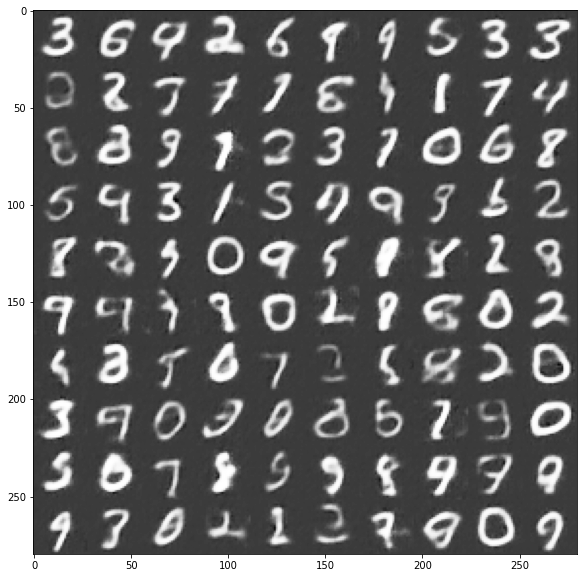

In [58]:
z_sample=[]
k=0
zz=np.random.normal(size=(int(nprob[k]), latent_dim)) 
z_sample.append(zz)
for k in range(1,center):
        zz=np.random.normal(size=(int(nprob[k]), latent_dim))
        z_sample.append(zz)
a=decoder_cov(decoder_linear(z_sample[0])[:,(0*intermediate_dim):((0+1)*intermediate_dim)])
for i in range(1,center):
   a=tf.concat([decoder_cov(decoder_linear(z_sample[i])[:,(i*intermediate_dim):((i+1)*intermediate_dim)]),a],axis=0)
a=tf.random.shuffle(a) 
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(convert_to_display(a), cmap='Greys_r')
 
 

In [59]:
def MMD(x, y,aa):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape),
                  torch.zeros(xx.shape),
                  torch.zeros(xx.shape))
    
     
    # XX += torch.exp(-0.5*dxx/(784*1))
    # YY += torch.exp(-0.5*dyy/(784*1))
    # XY += torch.exp(-0.5*dxy/(784*1))
      
    XX += aa*2*784/(aa*2*784+dxx)
    YY += aa*2*784/(aa*2*784+dyy)
    XY += aa*2*784/(aa*2*784+dxy)

    return 1000*torch.mean(XX + YY - 2. * XY)

In [60]:

x_test=torch.Tensor(x_test)
score=[]
for kk in range(5):
  nnprob[0]=nnprob[0]+10000-np.sum(nnprob)
  z_sample=[]

  for i in range(center):
        z_sample.append(np.random.normal(size=(int(nnprob[i]), latent_dim)))
  a=decoder_cov(decoder_linear(z_sample[0])[:,(0*intermediate_dim):((0+1)*intermediate_dim)])
  for i in range(1,center):
    a=tf.concat([decoder_cov(decoder_linear(z_sample[i])[:,(i*intermediate_dim):((i+1)*intermediate_dim)]),a],axis=0)
  x_test=np.reshape(x_test,[x_test.shape[0],28*28])
  a=a.numpy()
  a=np.reshape(a,[a.shape[0],28*28])
  a=torch.Tensor(a)
  
  score.append(MMD(a,x_test,0.5)+MMD(a,x_test,1)+MMD(a,x_test,2))
  print(score[kk])

tensor(2.3399)
tensor(2.4633)


KeyboardInterrupt: ignored

In [ ]:
print(tf.math.reduce_mean(tf.concat(score,axis=0)))
print(tf.math.reduce_std(tf.concat(score,axis=0)))
